# Sleep ECoG Processing 
##### my attempts to do this all in Python...

- Frequency band power analysis between sleep + wake data sets
- subject a0f66459, day 6

## Outline
- options
- load raw data
- separate out grid channels (1-64) and sleep vs. wake (1 hour each)
- visualize all 64 channels
- id channel 37 as bad - remove from set
- reshape into 20 trials 
- get power bands
- t-test, bar plot
- classify sleep vs. wake


In [28]:
# import things that might be useful to me
%matplotlib inline

# general use
import numpy as np
import pandas as pd 
import time
import h5py
import math
import os.path
import scipy as sp
from scipy import signal
from scipy import stats
from sklearn import preprocessing

# plotting
import matplotlib.pyplot as plt
plt.tight_layout()
import altair as alt
import seaborn as sns; sns.set()

# machine learning
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# custom functions here
import filtering_tools as filt

print('Pandas version:',pd.__version__)

Pandas version: 0.25.1


<Figure size 432x288 with 0 Axes>

In [2]:
# options
plot_on = 1;
save_on = 0;

In [3]:
# load raw data
subj_id = 'a0f66459'
day = '6'
filename = r"C:\Users\sunh20\Documents\Projects\SleepClass_SS\DATA\ecog\processed_" + subj_id + "_" + day + ".h5"
fin = h5py.File(filename, "r")
print(list(fin.keys()))
ecog_d = fin.get('dataset')
fs = int(fin.get('f_sample')[()])
chan_label = fin.get('chanLabels')


['Kurt_channels', 'SD_channels', 'allChanArtifactInds', 'chanLabels', 'dataset', 'f_sample', 'goodChanInds', 'standardizeDenoms', 'start_timestamp', 'start_timestamp_nw']


In [4]:
# data information
print('These are your variables:')
print('ecog_d:', ecog_d.shape, ecog_d.dtype)
print('fs:',fs)
print('chan_label:', chan_label.shape, chan_label.dtype)
print()
print(chan_label[()])

These are your variables:
ecog_d: (129, 42764078) float32
fs: 500
chan_label: () object

['Event', 'GRID1', 'GRID2', 'GRID3', 'GRID4', 'GRID5', 'GRID6', 'GRID7', 'GRID8', 'GRID9', 'GRID10', 'GRID11', 'GRID12', 'GRID13', 'GRID14', 'GRID15', 'GRID16', 'GRID17', 'GRID18', 'GRID19', 'GRID20', 'GRID21', 'GRID22', 'GRID23', 'GRID24', 'GRID25', 'GRID26', 'GRID27', 'GRID28', 'GRID29', 'GRID30', 'GRID31', 'GRID32', 'GRID33', 'GRID34', 'GRID35', 'GRID36', 'GRID37', 'GRID38', 'GRID39', 'GRID40', 'GRID41', 'GRID42', 'GRID43', 'GRID44', 'GRID45', 'GRID46', 'GRID47', 'GRID48', 'GRID49', 'GRID50', 'GRID51', 'GRID52', 'GRID53', 'GRID54', 'GRID55', 'GRID56', 'GRID57', 'GRID58', 'GRID59', 'GRID60', 'GRID61', 'GRID62', 'GRID63', 'GRID64', 'LID1', 'LID2', 'LID3', 'LID4', 'LID5', 'LID6', 'LID7', 'LID8', 'LAT1', 'LAT2', 'LAT3', 'LAT4', 'LAT5', 'LAT6', 'LMT1', 'LMT2', 'LMT3', 'LMT4', 'LPT1', 'LPT2', 'LPT3', 'LPT4', 'LPT5', 'LPT6', 'LTO1', 'LTO2', 'LTO3', 'LTO4', 'LTO5', 'LTO6', 'EOGL', 'EOGR', 'ECGL', 'ECGR'

In [5]:
# separate out grid data
# first index = event data (ignore)
ECOG_data = ecog_d[1:65,].transpose();
print('ECOG_data:',ECOG_data.shape)

ECOG_data: (42764078, 64)


In [20]:
# get sleep and wake times
t_start = 8*60*60 + 13*60 + 24 # seconds

# get sleep and wake times
t_wake = 8*60*60 + 59*60 + 36
t_sleep = 8*60*60 + 16*60*60 + 59*60 + 36

# adjust to get start indices for wake + sleep
t_wake = (int)((t_wake - t_start)*fs)
t_sleep = (int)((t_sleep - t_start)*fs)
# t = np.arange(0,60*60,1/fs)
t = np.arange(0,60*60*6.5,1/fs) # try 8 hours of data


data_wake = ECOG_data[t_wake:t_wake+fs*math.ceil(t[-1]),]
data_sleep = ECOG_data[t_sleep:t_sleep+fs*math.ceil(t[-1]),]

print('t:',t.shape)
print('data_wake:', data_wake.shape)
print('data_sleep:', data_sleep.shape)

t: (11700000,)
data_wake: (11700000, 64)
data_sleep: (11700000, 64)


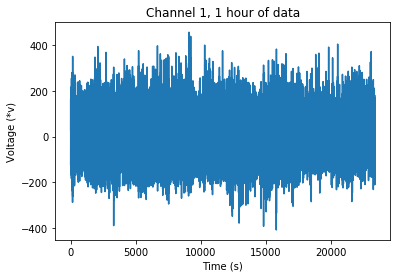

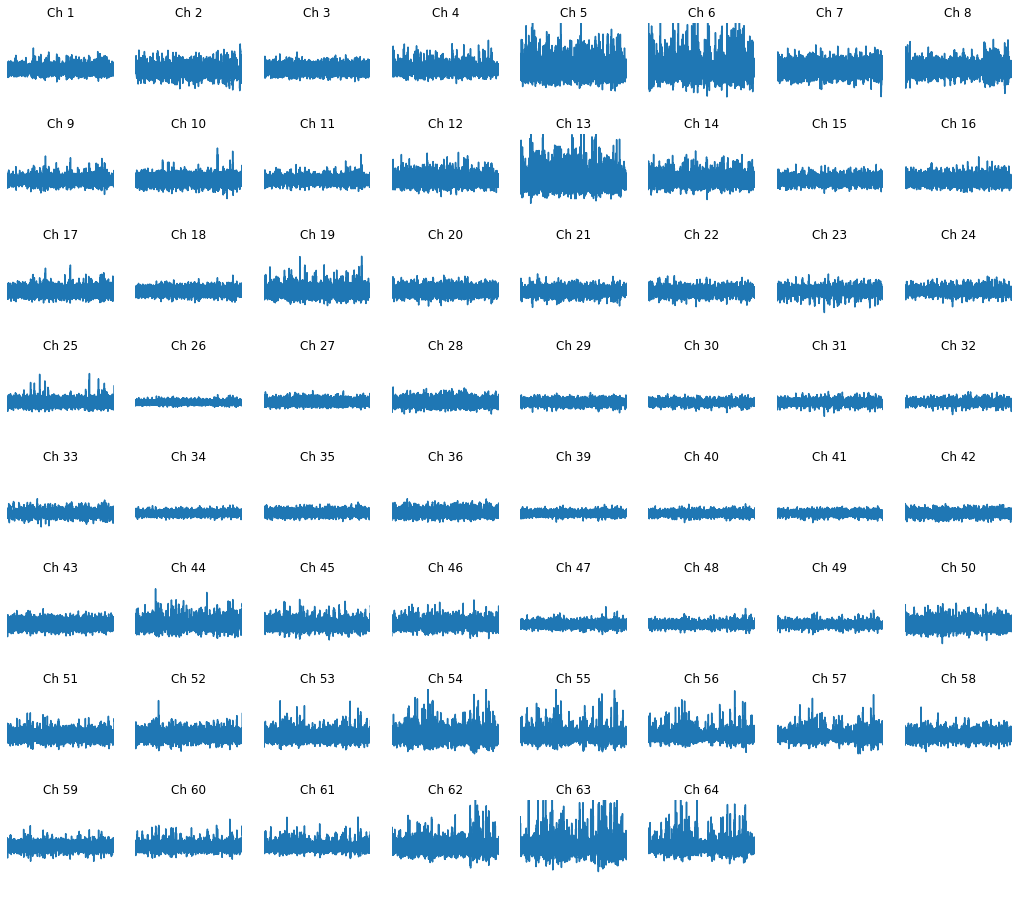

In [15]:
# visualize 64 channels
if plot_on:
    plt.figure
    plt.plot(t,data_wake[:,1])
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (*v)')
    plt.title('Channel 1, 1 hour of data')
    plt.figure(figsize=(18,16))
    
    for ch in range(chan.shape[0]):
        plt.subplot(8,8,ch+1)
        plt.box(False)
        plt.plot(t[0:90000],data_wake[0:90000,ch])
        plt.axis([0, 60, -400, 400])
        plt.title('Ch ' + str(chan[ch]))
        plt.xticks(ticks=[], labels=[])
        plt.yticks(ticks=[], labels=[])
    

In [21]:
# remove ch 37 + make list of channels
chan = np.arange(1,65)
chan = np.delete(chan,37-1)

data_wake = np.delete(data_wake,37-1,1)
data_sleep = np.delete(data_sleep,37-1,1)

print('Removed channel 37')
print('data_wake:', data_wake.shape)
print('data_sleep:', data_sleep.shape)

Removed channel 37
data_wake: (11700000, 63)
data_sleep: (11700000, 63)


In [22]:
# reshape 

# function that splits data into segments of specified length
# if cannot evenly split, trims the last bit of data + prints out how many data points lost
# inputs: 
#         data - original data
#         fs - sampling frequency
#         splice - length of segments (in seconds)
#         axis - dimension to splice (auto=0)
# example: 60 minute signal to be spliced into 3 min segments
# dat_split = time_splice(dat,fs,3*60)

def time_splice(data, fs, splice, axis=0):
    
    num_splices = int(np.floor(data.shape[axis]/splice/fs))
    data_lost = data.shape[axis]%(splice*fs)
    trim = False
                           
    print('input data length:', data.shape[axis]/fs, 'seconds')
    print('time splice length:',splice,'seconds')
    print('number of splices:', num_splices)
                           
    if data.shape[axis]%splice*fs != 0:
        print('Will need to trim some of data to split evenly')
        print('Losing',data_lost,'data points')
        trim = True
    
    if trim:
        data_splice = data[:-data_lost]
    else:
        data_splice = data
        
    # put into new array
    data_splice = np.reshape(data_splice,[num_splices,fs*splice,data.shape[axis+1]])
    print('data_split dimensions:',data_splice.shape)
    
    return data_splice

t_splice = 30 # seconds

data_wake_split = time_splice(data_wake,fs,t_splice)
data_sleep_split = time_splice(data_sleep,fs,t_splice)

num_trials = data_sleep_split.shape[0]

input data length: 23400.0 seconds
time splice length: 30 seconds
number of splices: 780
data_split dimensions: (780, 15000, 63)
input data length: 23400.0 seconds
time splice length: 30 seconds
number of splices: 780
data_split dimensions: (780, 15000, 63)


In [ ]:
# test that the filters work
data = data_sleep_split[0,:,:]
print(data.shape)

data_filt = filt.flex_filter(data,fs,12,30,btype='bandpass')
data_hilb = sp.signal.hilbert(data_filt)

if plot_on:
    plt.figure
    plt.plot(t[0:500],data[0:500,0],label='raw data')
    # plt.plot(t[0:500],data_filt[0:500,0],label='filtered data')
    plt.plot(t[0:500],data_hilb[0:500,0].real,label='hilbert data')
    plt.legend()
    plt.suptitle('beta band filtering + hilbert')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (uV)')
    plt.show()

# TODO: plot some avg spectral bands (signal.welch) for sleep + wake 
# average spectral bands here

In [23]:
# if pow_bands exists, load, otherwise process
load = False
path_pow_bands = subj_id  + '_pow_bands_' + str(t_splice) + '.npy'
if os.path.isfile(path_pow_bands) and load:
    pow_bands_sleep, pow_bands_wake = np.load(path_pow_bands)
    print('Completed loading power band data')
else:
    # get power bands
    
    # set frequencies
    pow_bands = [[1,4],[4,7],[8,13],[13,30],[30,70],[70,200]]
    
    # initialize power bands
    pow_bands_sleep = np.zeros((num_trials,len(pow_bands),chan.shape[0]))
    pow_bands_wake = np.zeros((num_trials,len(pow_bands),chan.shape[0]))

    start_time = time.time()
    
    # for each trial 
    for tr in range(num_trials):
        
        # get avg power for each frequency band
        for pwb in range(len(pow_bands)):
            f_low = pow_bands[pwb][0]
            f_high = pow_bands[pwb][1]

            d_sl = data_sleep_split[tr,:,:chan.shape[0]]

            data_filt = filt.flex_filter(d_sl,fs,f_low,f_high,btype='bandpass')
            data_hilb = sp.signal.hilbert(data_filt)
            hilb_pow = np.abs(data_hilb)**2
            pow_bands_sleep[tr][pwb] = np.mean(hilb_pow, axis=0)

            d_w = data_wake_split[tr,:,:chan.shape[0]]

            data_filt = filt.flex_filter(d_w,fs,f_low,f_high,btype='bandpass')
            data_hilb = sp.signal.hilbert(data_filt)
            hilb_pow = np.abs(data_hilb)**2
            pow_bands_wake[tr][pwb] = np.mean(hilb_pow, axis=0)

        print('completed trial',tr+1,'of', num_trials)
    print("--- %s seconds elapsed ---" % (time.time() - start_time))
    
    # save info
    if save_on:
        np.save(path_pow_bands, [pow_bands_sleep, pow_bands_wake, chan, num_trials, subj_id])
        print('Completed saving to file')



completed trial 1 of 780
completed trial 2 of 780
completed trial 3 of 780
completed trial 4 of 780
completed trial 5 of 780
completed trial 6 of 780
completed trial 7 of 780
completed trial 8 of 780
completed trial 9 of 780
completed trial 10 of 780
completed trial 11 of 780
completed trial 12 of 780
completed trial 13 of 780
completed trial 14 of 780
completed trial 15 of 780
completed trial 16 of 780
completed trial 17 of 780
completed trial 18 of 780
completed trial 19 of 780
completed trial 20 of 780
completed trial 21 of 780
completed trial 22 of 780
completed trial 23 of 780
completed trial 24 of 780
completed trial 25 of 780
completed trial 26 of 780
completed trial 27 of 780
completed trial 28 of 780
completed trial 29 of 780
completed trial 30 of 780
completed trial 31 of 780
completed trial 32 of 780
completed trial 33 of 780
completed trial 34 of 780
completed trial 35 of 780
completed trial 36 of 780
completed trial 37 of 780
completed trial 38 of 780
completed trial 39 of

In [24]:
# t-test
p_sleep_mean = np.mean(np.mean(pow_bands_sleep,axis=-1),axis=0)
p_wake_mean = np.mean(np.mean(pow_bands_wake,axis=-1),axis=0)

p_sleep_ste = stats.sem(np.mean(pow_bands_sleep,axis=-1),axis=0)
p_wake_ste = stats.sem(np.mean(pow_bands_wake,axis=-1),axis=0)

t_stat, pval = stats.ttest_ind(np.mean(pow_bands_sleep,axis=-1),np.mean(pow_bands_wake,axis=-1))

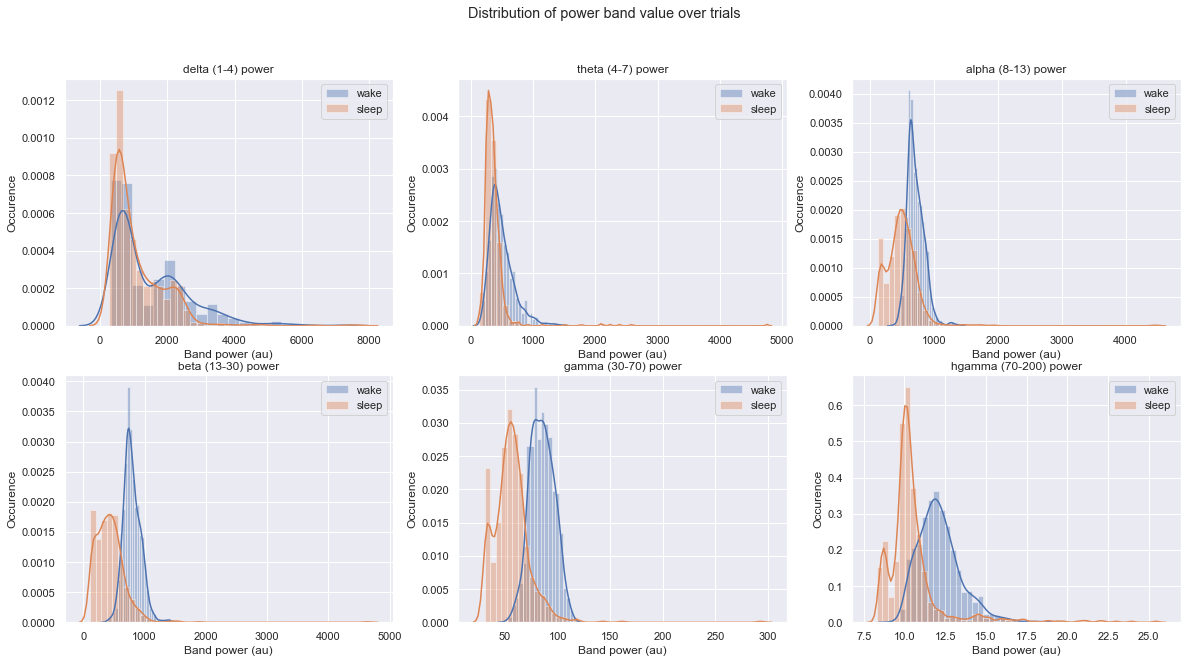

In [29]:
# plot distributions for each frequency band
bar_labels = ("delta (1-4)","theta (4-7)","alpha (8-13)",
              "beta (13-30)","gamma (30-70)","hgamma (70-200)")

p_wake = np.mean(pow_bands_wake,axis=-1)
p_sleep = np.mean(pow_bands_sleep,axis=-1)

p_wake_alpha = p_wake[:,0]
p_sleep_alpha = p_sleep[:,0]

fig = plt.figure(figsize=(20,10))
plt.suptitle('Distribution of power band value over trials')

for fband in range(6):
    plt.subplot(2,3,1+fband)
    sns.distplot(p_wake[:,fband],label='wake')
    sns.distplot(p_sleep[:,fband],label='sleep')
    plt.legend()
    plt.xlabel('Band power (au)')
    plt.ylabel('Occurence')
    plt.title(bar_labels[fband] +' power')

if save_on:
    fig.savefig(subj_id + '_fband_distrib.png', dpi=300)

# TODO: check bin sizing


In [ ]:
p_wake.shape

**Figure**: We performed a histogram analysis to determine whether these distributions are Gaussian, in preparation for parameter normalization. We observed a nice separation in distributions in the delta, beta, and gamma frequencies. Interestingly, in frequencies alpha and higher, we observe a distinct bimodal distribution, which may indicate that there are subcategories of dynamics that occur during sleep.

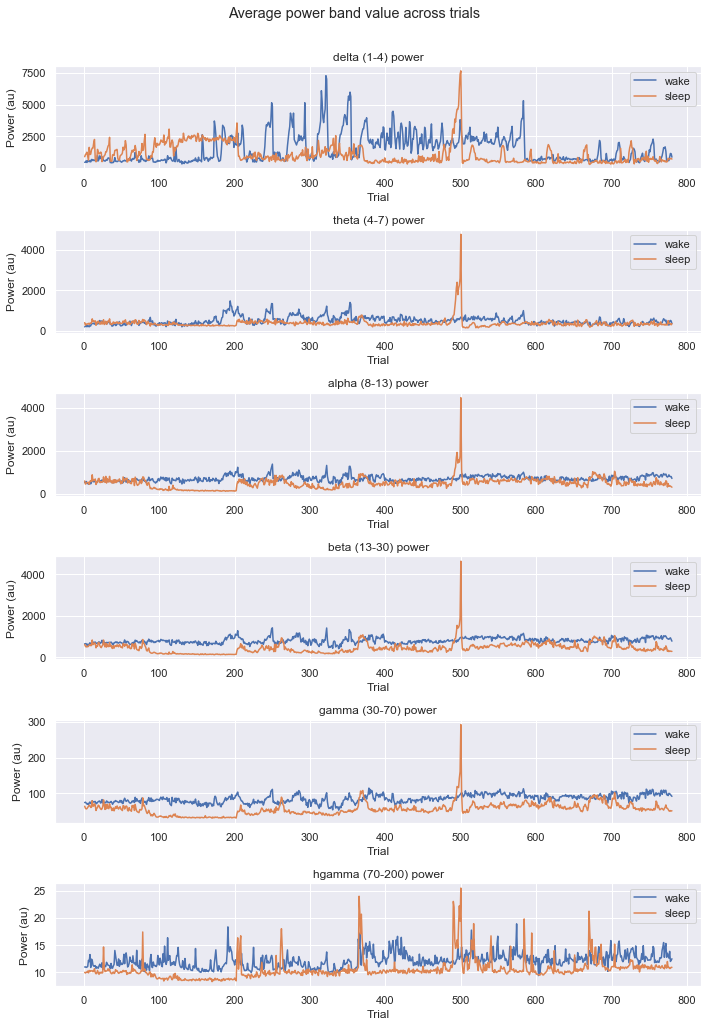

In [30]:
# plot distribution of frequencies over time

trials = np.arange(1,781)

fig = plt.figure(figsize=(10,15))
plt.suptitle('Average power band value across trials')

for fband in range(6):
    plt.subplot(6,1,1+fband)
    plt.plot(trials,p_wake[:,fband],label='wake')
    plt.plot(trials,p_sleep[:,fband],label='sleep')
    plt.xlabel('Trial')
    plt.ylabel('Power (au)')
    plt.legend()
    plt.title(bar_labels[fband] +' power')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

if save_on:
    fig.savefig(subj_id + '_power_across_trials.png', dpi=300)

**Figure:** A faux time series (plotting over trials) with each trial representing the average power over a time segment. A few observations: in the delta band, we see a periodic waveform in the sleep trace, with delta increasing over trials and then sharply decreasing. It appears as if the sharp decrease occurs about every 20 trials, or 10 minutes (if separated into 30-second segments). Perhaps there could be something that woke the patient up every 10 minutes? Around trial 90, we observe that this periodic signal ceases and instead has a sustained increase of delta power, and there is a clear decrease in power in the other frequency bands. This could be a strong indicator of the patient going into deeper stages of sleep, with the frequency of neural oscillations decreasing. 


In [ ]:
# bar plot mean pow bands

bar_labels = ("delta (1-4)","theta (4-7)","alpha (8-13)",
              "beta (13-30)","gamma (30-70)","hgamma (70-200)")
y_pos = np.arange(len(bar_labels))
bar_w = 0.3

if plot_on:
    plt.figure(figsize=(10,5))
    plt.bar(y_pos,p_sleep_mean,bar_w,
            yerr=p_sleep_ste,
            capsize=5,
            label='sleep',
            color='#3690c0')
    plt.bar(y_pos+bar_w,p_wake_mean,bar_w,
            yerr=p_wake_ste,
            capsize=5,
            label='wake',
            color='#d53e4f')
    plt.grid(False)
    plt.xticks(y_pos + bar_w/2, bar_labels)
    plt.xlabel('Frequency bins')
    plt.ylabel('Band Power')
    plt.legend()
    plt.suptitle('Mean power across frequency bands')

print('P-values:')

for i in np.arange(len(pval)):
    stars = '';
    p = pval[i]
    if p < 0.05:
        stars = stars + '*'
    if p < 0.01:
        stars = stars + '*'
    if p < 0.001:
        stars = stars + '*'
    print(bar_labels[i],'\t%.2g\t' % p,stars) 



In [ ]:
# pval for individual electrodes
t_stat_e, pval_e = stats.ttest_ind(pow_bands_wake,pow_bands_sleep,axis=0)
print('p-val for individual electrodes, delta band:')
pval_e[0]

In [ ]:
# train sleep classifier based on these 6 frequency band features
# Classifiers used: Logistic regression, lasso
# use feature normalization

# setup variables appropriately
X = np.concatenate((np.mean(pow_bands_sleep,axis=-1),np.mean(pow_bands_wake,axis=-1))); # features, N x 6 matrix
y = np.zeros((num_trials*2,1)); # binary vector - sleep vs. wake, should be N x 1
y[num_trials:] = 1;

# feature standardization
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

# split using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y.ravel(), test_size=0.2, random_state=0)

# try logistic regression
LR = sk.linear_model.LogisticRegression(random_state=0, # random seed
                                        solver='liblinear',
                                        ).fit(X_train,y_train)

LS = sk.linear_model.Lasso(random_state=0, alpha=0.05).fit(X_train,y_train)

# evaluate
print('Logistic Regression mean accuracy: ',LR.score(X_test,y_test))
print('Coefficients:',LR.coef_)
print()
print('Lasso mean accuracy: ',LS.score(X_test,y_test))
print('Coefficients:',LS.coef_)

In [ ]:
# train sleep classifier based on these 6 frequency band features x 63 electrodes
# Classifiers used: lasso

# setup variables appropriately
# setup so that it goes electrode 1-63 (delta), 1-63 (theta)...
X = np.concatenate([np.reshape(pow_bands_sleep,[num_trials,-1]), 
                   np.reshape(pow_bands_wake,[num_trials,-1])],
                   axis=0); 

# feature standardization
X = sk.preprocessing.normalize(X,axis=0,return_norm=True)[0]

y = np.zeros((num_trials*2,1)); # binary vector - sleep vs. wake, should be N x 1
y[num_trials:] = 1;

# split using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=0)

# lasso regression
LS = sk.linear_model.Lasso(random_state=0, 
                           alpha=0.5).fit(X_train,y_train)

# evaluate
print('Lasso mean accuracy: ',LS.score(X_test,y_test))

# coefficients: features x electrodes
LS_coef = np.reshape(LS.coef_,[pow_bands_sleep.shape[1],pow_bands_sleep.shape[2]])
LS_coef = pd.DataFrame(data=LS_coef.transpose(),
                         columns=bar_labels,
                         index=chan)
display(LS_coef)

In [ ]:
# do the same thing but now by electrode

# make dataframes for sleep + wake electrodes
p_e_wake = pd.DataFrame(data=np.mean(pow_bands_wake,axis=0).transpose(),
                        columns=bar_labels,
                        index=chan)
p_e_wake.index.name = 'Electrode'
p_e_sleep = pd.DataFrame(data=np.mean(pow_bands_sleep,axis=0).transpose(),
                         columns=bar_labels,
                         index=chan)
p_e_sleep.index.name = 'Electrode'

# make difference dataframe - normalized
p_e_diff = p_e_wake - p_e_sleep
p_e_diff_norm = pd.DataFrame(data=preprocessing.normalize(np.array(p_e_diff),axis=0),
                             columns=bar_labels,
                             index=chan)
if plot_on:
    fig = plt.figure(figsize=[24,12])
    ax = sns.heatmap(p_e_diff_norm.transpose(),square=True,center=0,cbar_kws={"orientation": "horizontal"})

if save_on:
    fig.savefig(subj_id + '_fband_diff_linear.png', dpi=300)

**Figure**: Heatmap showing the difference in frequency band power between wake vs. sleep (wake - sleep). Black indicates little difference, while blue indicates higher sleep band power and red indicates higher wake band power. We observe that there are electrode clusters that have preferentially increased band power in higher frequencies during wake (5-7, 12-14, 61-64). We also observe that electrodes 39-40 have preferentially increased band power in the lower frequencies during sleep.   
   
These observations suggest that these electrodes may be good candidates for predicting sleep vs. wake and may be located in brain regions that are functionally relevant or responsive to sleep/wake states.

In [ ]:
# 8x8 plots for each frequency band
chan = np.reshape(np.arange(1,65),[8,8])

if plot_on:
    fig = plt.figure(figsize=[16,20])
    plt.suptitle('Frequency power difference (wake-sleep)')
    for idx in np.arange(6):
        print()
        fband = bar_labels[idx]
        fdata = np.array(p_e_diff_norm[fband])
        
        # fill in electrode 36 -> nan
        fdata = np.insert(fdata,36,np.nan)
        
        # same process with pval data
        pdata = pval_e[idx]
        pdata = np.insert(pdata,36,np.nan)

        # keep only fdata that pdata is < 0.05
        ch_nonsig = ""
        for pidx in np.arange(64):
            if pdata[pidx] >= 0.05:
                fdata[pidx] = 0
                ch_nonsig = ch_nonsig + str(pidx+1) + ","
        print('nonsignificance @ ch ' + ch_nonsig + ' for ' + fband)
        
        # reshape before plotting
        fdata = np.reshape(fdata,[8,8])
        
        plt.subplot(3,2,idx+1)
        plt.title(fband)
        ax = sns.heatmap(fdata,square=True,
                         center=0,
                         annot=chan,
                         xticklabels=False,
                         yticklabels=False,
                         vmin=-0.5, vmax=0.5)


In [ ]:
# save figure
if save_on:
    fig.savefig(subj_id + '_fband_diff.png', dpi=300)

In [ ]:
# train sleep classifer by electrode

In [ ]:
# video of delta power over time for the 64 electrodes
# reference: https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c
# another: http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

In [ ]:
# practice indexing lol
import numpy as np

a = np.array([[1, 2, 3, 0],[4, 5, 6, 0],[7, 8, 9, 0],[10, 11, 12, 0]])
print(a)

print(a[0,0])
print(a[2,2])

print(a[0:1,0])
print(a[0:2,0])

a = a.reshape([2, 2, 4])
print(a)
print(a[0,0,0])
print(a[0,0,1])
print(a**2)

In [ ]:
# some useful code i want to keep

# my tic toc
# start_time = time.time()
#print("--- %s seconds elapsed ---" % (time.time() - start_time))

# whos - will tell me all the variables in current workspace

# save to file
# np.save('test1.txt', a, fmt='%d')

In [ ]:
whos